In [1]:
#!pip install git+https://github.com/tensorflow/docs

In [25]:
import pathlib
import shutil
import tempfile

from   IPython import display
from   matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from   tensorflow.keras import layers, regularizers, Sequential
from   tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from   tensorflow.keras.layers import Dense
from   tensorflow.keras.losses import BinaryCrossentropy
from   tensorflow.keras.optimizers import Adam, schedules
import tensorflow_docs as tfdocs
from   tensorflow_docs import modeling, plots

tf.__version__

'2.4.0'

In [3]:
logdir = pathlib.Path(tempfile.mkdtemp())/'tensorboard_logs'
shutil.rmtree(logdir, ignore_errors=True)

In [4]:
gz = tf.keras.utils.get_file(
    'HIGGS.csv.gz', 
    'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

In [5]:
FEATURES = 28

In [6]:
ds = tf.data.experimental.CsvDataset(gz, [float(), ] * (FEATURES + 1), 
                                     compression_type='GZIP' )

In [7]:
def pack_row(*row):
    label = row[0]
    features = tf.stack(row[1:], 1)
    return features, label

In [8]:
packed_ds = ds.batch(10_000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


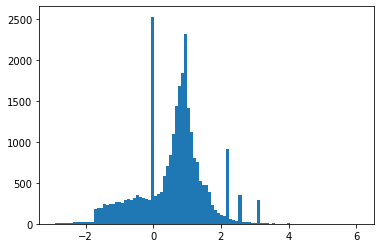

In [9]:
for features, label in packed_ds.batch(1000).take(1):
    print(features[0])
    plt.hist(features.numpy().flatten(), bins=101)

In [10]:
N_VALID = 1000
N_TRAIN = 10_000
BUFFER = 10_000
BATCH = 500
STEPS_PER_EPOCH = N_TRAIN // BATCH

In [11]:
valid_ds = packed_ds.take(N_VALID).cache()
train_ds = packed_ds.skip(N_VALID).take(N_TRAIN).cache()
train_ds

<CacheDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>

In [12]:
valid_ds = valid_ds.batch(BATCH)
train_ds = train_ds.shuffle(BUFFER).repeat().batch(BATCH)

## Overfit Demo

In [15]:
lr_schedule = schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH * 1000,
    decay_rate=1,
    staircase=False)

In [16]:
def get_optimizer():
    return Adam(lr_schedule)

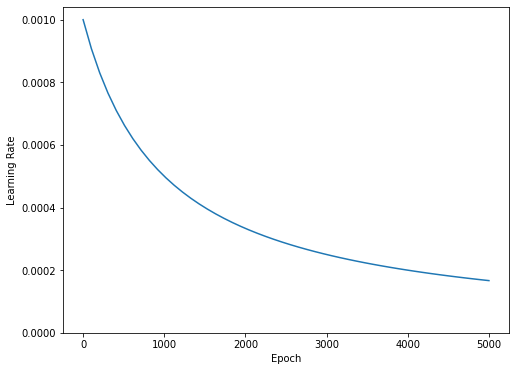

In [18]:
step = np.linspace(0, 100_000)
lr = lr_schedule(step)
plt.figure(figsize=(8, 6))
plt.plot(step / STEPS_PER_EPOCH, lr)
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Learning Rate');

In [35]:
def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        EarlyStopping(monitor='val_bxe', patience=200),
        TensorBoard(logdir/name)]

In [36]:
def compile_and_fit(mod, name, optimizer=None, max_epochs=10_000):
    optimizer = get_optimizer() if optimizer is None else optimizer
    mod.compile(optimizer=optimizer,
               loss=BinaryCrossentropy(from_logits=True),
               metrics=[BinaryCrossentropy(from_logits=True, name='bxe'),
                        'accuracy'])
    mod.summary()
    hist = mod.fit(train_ds,
                   steps_per_epoch=STEPS_PER_EPOCH,
                   epochs=max_epochs,
                   validation_data=valid_ds,
                   callbacks=get_callbacks(name),
                   verbose=0)
    return hist

In [37]:
tiny_mod = Sequential([
    Dense(16, activation='relu', input_shape=(FEATURES,)),
    Dense(1)])

In [38]:
size_histories = {'Tiny': compile_and_fit(tiny_mod, 'sizes/Tiny')}

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4753,  bxe:0.9218,  loss:0.9218,  val_accuracy:0.4620,  val_bxe:0.8397,  val_loss:0.8397,  
....................................................................................................
Epoch: 100, accuracy:0.6105,  bxe:0.6173,  loss:0.6173,  val_accuracy:0.5890,  val_bxe:0.6284,  val_loss:0.6284,  
....................................................................................................
Epoch: 200, accuracy:0.6456,  bxe:0.6006,  loss:0.6006,  val_accuracy:0.6430,  val_bxe:

(0.5, 0.7)

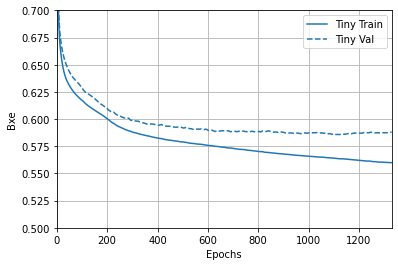

In [40]:
plotter = tfdocs.plots.HistoryPlotter(metric='bxe', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

In [41]:
small_mod = Sequential([
    Dense(16, activation='relu', input_shape=(FEATURES,)),
    Dense(16, activation='relu'),
    Dense(1)
])

In [43]:
size_histories['Small'] = compile_and_fit(small_mod, 'sizes/Small')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_9 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 17        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4890,  bxe:0.7212,  loss:0.7212,  val_accuracy:0.4630,  val_bxe:0.7157,  val_loss:0.7157,  
....................................................................................................
Epoch: 100, accuracy:0.6389,  bxe:0.6032,  loss:0.6032,  val_accuracy:0.5880,  val_bxe:0.6276,  val_loss:0.6276,  
........................................................

In [45]:
medium_mod = Sequential([
    Dense(64, activation='relu', input_shape=(FEATURES,)),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
])

In [46]:
size_histories['Medium']  = compile_and_fit(medium_mod, "sizes/Medium")

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 64)                1856      
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4749,  bxe:0.6975,  loss:0.6975,  val_accuracy:0.4600,  val_bxe:0.6859,  val_loss:0.6859,  
....................................................................................................
Epoch: 100, accuracy:0.8443,  bxe

In [47]:
large_mod = Sequential([
    Dense(512, activation='relu', input_shape=(FEATURES,)),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(1)
])
size_histories['large'] = compile_and_fit(large_mod, "sizes/large")

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_17 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_18 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4798,  bxe:0.6949,  loss:0.6949,  val_accuracy:0.4620,  val_bxe:0.6768,  val_loss:0.6768,  


Text(0.5, 0, 'Epochs [Log Scale]')

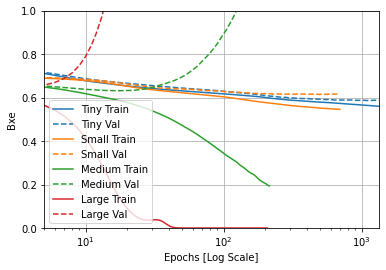

In [53]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0., 1])
plt.xlabel("Epochs [Log Scale]")